## Time Series Analysis (Seasonal ARIMA)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
import pandas as pd
import numpy as np

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)

plt.rc('axes', labelsize = 14)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)
plt.rc('text', color = 'k')

In [3]:
sales_df = pd.read_excel('Superstore.xls')

## Analyze and Forecast Furniture Sales

In [4]:
furniture_sales = sales_df[sales_df['Category'] == 'Furniture']

In [5]:
print('Data avail for',
      furniture_sales['Order Date'].min(),
      'to',
      furniture_sales['Order Date'].max())

Data avail for 2014-01-06 00:00:00 to 2017-12-30 00:00:00


##### Preprocessing

In [6]:
furniture_sales.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [7]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Quantity', 'Discount', 'Profit']
furniture_sales.drop(cols, axis=1, inplace=True)
furniture_sales = furniture_sales.sort_values('Order Date')

In [8]:
furniture_sales.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [9]:
furniture_sales = furniture_sales.groupby('Order Date')['Sales'].sum().reset_index()

In [10]:
furniture_sales.set_index('Order Date', inplace=True)

##### Look at mean monthly furniture sales

In [11]:
y  = furniture_sales['Sales'].resample('MS').mean()

In [12]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

##### Visualization

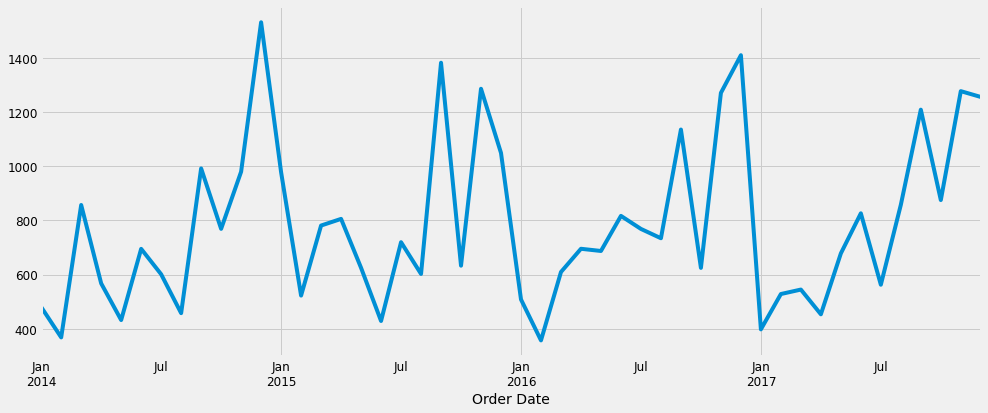

In [13]:
y.plot(figsize=(15, 6))
plt.show()

Note seasonality

##### Time Series Decomposition

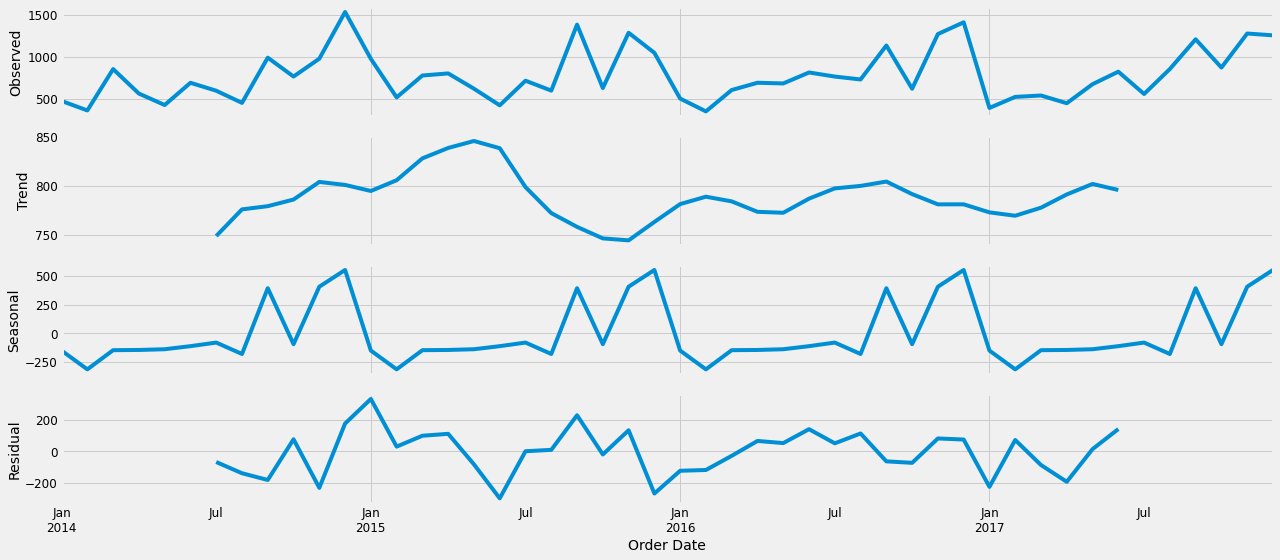

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y,
                                         model='additive')
fig = decomposition.plot()
plt.show()

Residuals and trend-cycle point to unstable sales

### Forecast Using ARIMA

ARIMA$(p, d, q)$
<br> Seasonality, trend, noise

Use grid search to test and find optimal parameters for model

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

#Seasonal ARIMA characterized by additional term, m: Number of time steps in a single seasonal period.
#As we are using monthly data, m=12
seasonal_pdq = [(x[0],
                 x[1],
                 x[2],
                 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, 
                                                 param_seasonal, 
                                                 results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1637.7461032046563
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920899
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1356.7995203388523
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2923.690712804946
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809158
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5275878870793
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2706.8739626533925
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468646
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1261.3387491517244
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672282035
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1100.9541279215728
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARI

$AIC$ value for $SARIMAX(1, 1, 1)x(1, 1, 0, 12)$ is lowest, should use

#### Fit ARIMA

In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(1,1,1),
                               seasonal_order=(1,1,0,12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


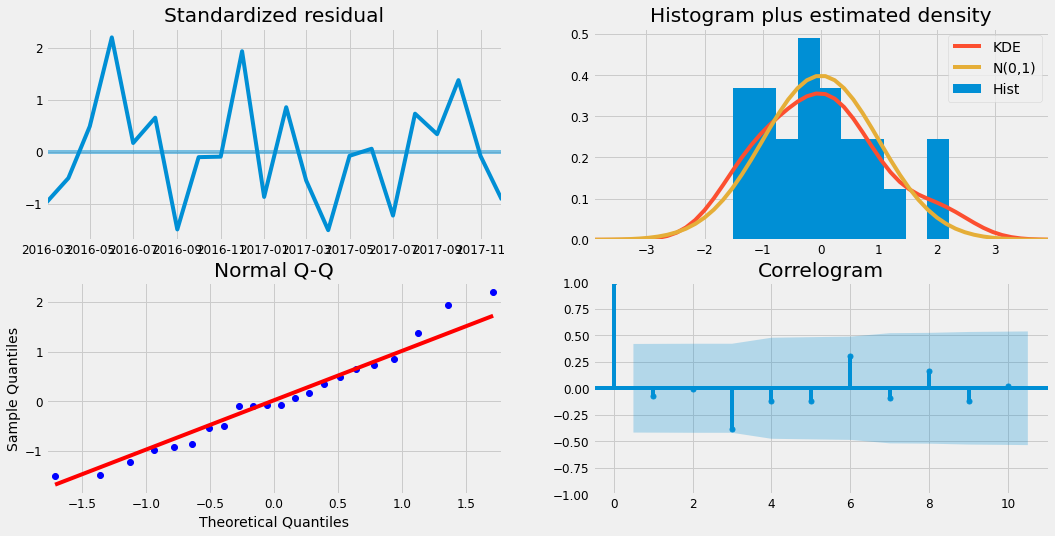

In [18]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Daignostics tell us we have a decent fit given:
1. No obvious pattern in residulas
2. KDE curve close to normally distributed
3. Q-Q Plot points lie on 45 degree line for the most part
4. Correlations for lag greater than one not significant

### Forecast Validation

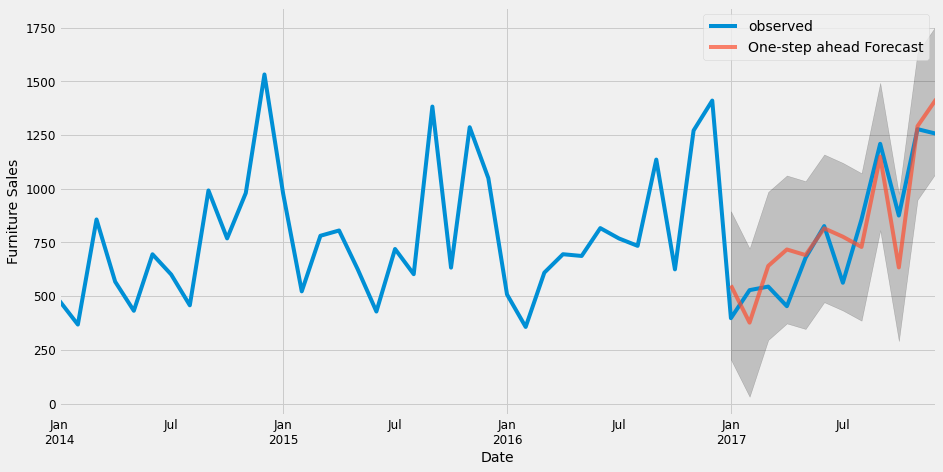

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),
                              dynamic=False)
pred_ci = pred.conf_int()

#plot observed
ax = y['2014':].plot(label='observed')
#plot predicted
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
#plot CI
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Squared Error (MSE) of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error (RMSE) of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error (MSE) of our forecasts is 22993.57
The Root Mean Squared Error (RMSE) of our forecasts is 151.64


In [21]:
print('The RMSE of {} can be compared to the monthly sales min of {} and max of {}'.format(round(np.sqrt(mse), 2),
                                                                                            round(y.min(), 2), 
                                                                                            round(y.max(), 2))
     )

The RMSE of 151.64 can be compared to the monthly sales min of 356.87 and max of 1532.3
